---
### 招聘公务员问题
> 2004年国赛D题

In [1]:
import numpy as np
import sympy as sp
sp.init_printing(use_latex=True)
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Times New Roman + SimSun + WFM Sans SC']
plt.rcParams['mathtext.fontset']='stix'
# Times New Roman + SimSun + WFM Sans SC
# simsum宋体, times new roman -*, simhei黑体, kaiti楷体, 
# dengxian等线, fangsong仿宋, Microsoft Yahei微软雅黑
plt.rcParams['axes.unicode_minus']=False   
plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = [4, 3]
# plt.rcParams['font.size'] = 12
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'

In [34]:
v = np.array([1, 2, 3, 4, 5])  # 评语集 v = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}
f1 = 0.01
f3 = 0.8
f5 = 1
alpha, beta, a, b = sp.symbols('α, β, a, b', real=True)
x = sp.symbols('x', integer=True)
f1_3 = (1+alpha*(x - beta)**-2)**-1     # 柯西分布隶属函数
f3_5 = a*sp.log(x) + b

In [16]:
eq1 = sp.Equality(f1_3.subs(x, 1), f1)
eq2 = sp.Equality(f1_3.subs(x, 3), f3)
ret1_3 = sp.nonlinsolve([eq1, eq2], [alpha, beta])
ret1_3
# 此处有两组解，下面使用第二组，因为第一组对应的隶属函数非单调递增

In [18]:
alpha_r, beta_r = list(ret1_3)[1]
ff1_3 = sp.lambdify(x, f1_3.subs({alpha: alpha_r, beta: beta_r}), 'numpy')
f2 = ff1_3(2)
ff1_3(1), ff1_3(3), f2

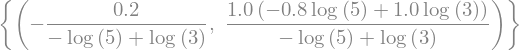

In [5]:
eq3 = sp.Eq(f3_5.subs(x, 3), 0.8)
eq4 = sp.Eq(f3_5.subs(x, 5), 1)
ret3_5 = sp.nonlinsolve([eq3, eq4], [a, b])
ret3_5

In [19]:
a_r, b_r = list(ret3_5)[0]
a_r, b_r = a_r.n(), b_r.n()
ff3_5 = sp.lambdify(x, f3_5.subs({a: a_r, b: b_r}), 'numpy')
f4 = ff3_5(4)
ff3_5(3), ff3_5(5), f4

In [62]:
def membership_f(x):
    if (1 <= x and x <= 3):
        return ff1_3(x)
    elif (3 <= x and x <= 5):
        return ff3_5(x)

quant_score = list(map(membership_f, v))

def score(x):
    return quant_score[int(x-1)]

data = np.loadtxt('../../14第14章  综合评价方法/anli14_1_1.txt')
for i in range(len(data)):
    for j in range(3, len(data[0])):
        data[i, j] = score(data[i, j])

retest = data[:, 3:].mean(axis=1)   # 对四项评分取相同的权重
retest          # 复试成绩

array([0.95631708, 0.92815854, 0.80928239, 0.93447562, 0.90631708,
       0.83744093, 0.90631708, 0.92815854, 0.93447562, 0.80928239,
       0.80928239, 0.92815854, 0.80928239, 0.83744093, 0.90631708,
       0.90631708])

In [72]:
from sklearn.preprocessing import minmax_scale

score = np.array([data[:, 0], retest]).T
score_std = minmax_scale(score, axis=0) # 极差变换法
score_std       # 规范化成绩

array([[1.00000000e+00, 1.00000000e+00],
       [8.82352941e-01, 8.08490504e-01],
       [8.82352941e-01, 0.00000000e+00],
       [7.05882353e-01, 8.51453695e-01],
       [5.88235294e-01, 6.59944199e-01],
       [5.88235294e-01, 1.91509496e-01],
       [4.11764706e-01, 6.59944199e-01],
       [4.11764706e-01, 8.08490504e-01],
       [4.11764706e-01, 8.51453695e-01],
       [4.11764706e-01, 8.88178420e-16],
       [2.94117647e-01, 8.88178420e-16],
       [2.35294118e-01, 8.08490504e-01],
       [1.17647059e-01, 8.88178420e-16],
       [1.17647059e-01, 1.91509496e-01],
       [5.88235294e-02, 6.59944199e-01],
       [0.00000000e+00, 6.59944199e-01]])

In [74]:
gamma = 0.5
performance = score_std[:, 0]*gamma + score_std[:, 1]*(1 - gamma)
performance


array([1.        , 0.84542172, 0.44117647, 0.77866802, 0.62408975,
       0.38987239, 0.53585445, 0.61012761, 0.6316092 , 0.20588235,
       0.14705882, 0.52189231, 0.05882353, 0.15457828, 0.35938386,
       0.3299721 ])